### Monte Carlo Pricing Simulation with Brownian Motion

Monte Carlo simulation is a widely used technique to estimate option prices by simulating the future paths of the underlying asset. In this method, **Geometric Brownian Motion (GBM)** is used to model the evolution of the asset price over time.
### Key Points:

- **Geometric Brownian Motion** is used to model asset price changes over time.
  
- **Monte Carlo simulation** generates multiple random paths of the asset's price to estimate the expected payoff.

- **Risk-neutral pricing** assumes the asset grows at the risk-free rate $r$, allowing us to discount future payoffs.

- The **Law of Large Numbers** ensures that as the number of simulations increases, the estimated option price converges to its true value.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### 1. **Geometric Brownian Motion (GBM)**

The stock price $( S_t $) is modeled as following a stochastic process known as **Geometric Brownian Motion (GBM)**, defined by the stochastic differential equation:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

Where:
- $( \mu $) is the drift (expected return of the asset).
- $( \sigma $) is the volatility (standard deviation of returns).
- $( W_t $) is a Wiener process (Brownian motion).

In risk-neutral pricing, the drift $( \mu $) is replaced by the risk-free rate $( r $). This is because under the risk-neutral measure, the expected return of any asset is equal to the risk-free rate, which allows us to discount future payoffs at the risk-free rate.

The solution to the GBM is:

$$ S_t = S_0 \exp \left( \left( r - \frac{1}{2} \sigma^2 \right) t + \sigma W_t \right) $$

#### 2. **Simulating Asset Paths**

The Monte Carlo simulation breaks down the continuous-time evolution of the asset price into discrete time steps. The time increment $( \Delta t $) between each step is:

$$ \Delta t = \frac{T}{\text{nb\_steps}} $$

At each step, the asset price evolves based on the following formula:

$$ S_{t+1} = S_t \exp \left( \left( r - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} Z \right) $$

Where $( Z $) is a standard normal random variable that models the random shocks in asset price movements. 

The above code simulates **nb\_simul** paths of the asset price over **nb\_steps** time intervals. Each path starts at the initial stock price $( S_0 $) and is updated iteratively based on the GBM formula.

#### 3. **Option Payoff Calculation**

At the maturity time $( T $), the option payoff is calculated based on the type of option:

- For a **call option**, the payoff is:

$$ \text{Payoff} = \max(S_T - K, 0) $$

- For a **put option**, the payoff is:

$$ \text{Payoff} = \max(K - S_T, 0) $$

Where $( K $) is the strike price, and $( S_T $) is the asset price at maturity.

#### 4. **Discounting the Payoffs**

Since the payoffs are received at maturity, they must be discounted back to the present value using the risk-free rate $( r $):

$$ \text{Option Price} = e^{-rT} \times \text{Expected Payoff} $$

The Monte Carlo method averages the payoffs from all simulated paths and discounts them to estimate the option price.


In [2]:
def mc_full_path(s, r, vol, T, k, type, nb_simul, nb_steps):
    dt = T / nb_steps 
    
    # Simulate nb_simul paths with nb_steps (time points)
    asset_paths = np.zeros((nb_simul, nb_steps + 1))
    asset_paths[:, 0] = s  # Initial price for all paths
    
    for t in range(1, nb_steps + 1):
        z = np.random.normal(0, 1, nb_simul)
        # Simulate next asset price based on previous price
        asset_paths[:, t] = asset_paths[:, t-1] * np.exp((r - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z)

    # Take the price at maturity (final column)
    St = asset_paths[:, -1]

    # Calculate payoffs for call or put option
    payoff = np.maximum(St-k, 0) if type == "call" else np.maximum(k-St, 0)

    # Discount payoffs back to present value
    option_price = np.exp(-r * T) * np.mean(payoff)
    
    return option_price, asset_paths

### Why Getting the Whole Price Path is Not Necessary for a Monte Carlo Approach

In a **Monte Carlo simulation** for option pricing, the key objective is to estimate the expected payoff of an option at maturity. While it's possible to simulate the entire price path of an asset over time, doing so is not always necessary for all option types.

#### Key Insights:
1. **European Options** (which can only be exercised at maturity):
   - The payoff of a European option depends only on the asset price at maturity, not on the entire path the asset took to get there.
   - For these options, it's sufficient to directly simulate the asset's final price at maturity $T$ using a **single-step simulation**:
     $$[
     S_T = S_0 \exp \left( (r - \frac{1}{2} \sigma^2) T + \sigma \sqrt{T} Z \right)
     $$]
     where $Z \sim \mathcal{N}(0, 1)$ is a random normal variable, $r$ is the risk-free rate, and $\sigma$ is the volatility.

2. **Full Path Simulation** (used in path-dependent options):
   - For options like **Asian options**, **Barrier options**, or **Lookback options**, the payoff depends on the price history, such as the average price or whether the asset crosses certain thresholds. In these cases, simulating the entire price path using **multiple time steps** is required.
   - In a full path simulation, we divide the time horizon $T$ into smaller intervals (say, $dt = T / N$, where $N$ is the number of steps) and evolve the asset price incrementally using:
     $$[
     S_{t+dt} = S_t \exp \left( \left( r - \frac{1}{2} \sigma^2 \right) dt + \sigma \sqrt{dt} Z_t \right)
     $$]
     where $Z_t$ is a normally distributed random variable.

In [3]:
s = 100
k = 105
r = 0.04
vol = 0.2
T = 1
nb_simul = 10000
nb_steps = 252

option_price, asset_paths = mc_full_path(s, r, vol, T, k, "call", nb_simul, nb_steps)
print("Option Price: ", option_price)

Option Price:  7.501258628690372


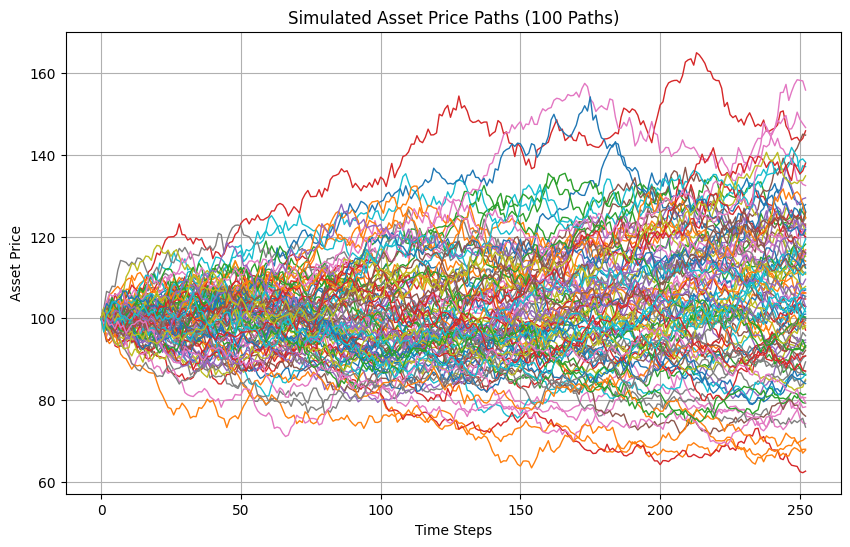

In [4]:
plt.figure(figsize=(10, 6))
to_plot = 100
for i in range(to_plot):
	plt.plot(asset_paths[i], lw=1)
plt.title(f"Simulated Asset Price Paths ({to_plot} Paths)")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

### Convergence of Monte Carlo Option Pricing with Increasing Simulations

Monte Carlo simulation is used to estimate the price of options by generating random price paths for the underlying asset. The accuracy of this estimate depends on the number of simulations. As the number of simulations increases, the estimated option price converges towards the true theoretical value due to the **Law of Large Numbers**.

- **Simulation Sizes:** The test runs Monte Carlo simulations with different sizes (10, 100, 1000, 10000) to observe how the option price and its standard deviation evolve.
- **Log-Scale Plot:** The error bars in the plot represent the standard deviation of option prices across multiple trials, which reduces as more simulations are added.

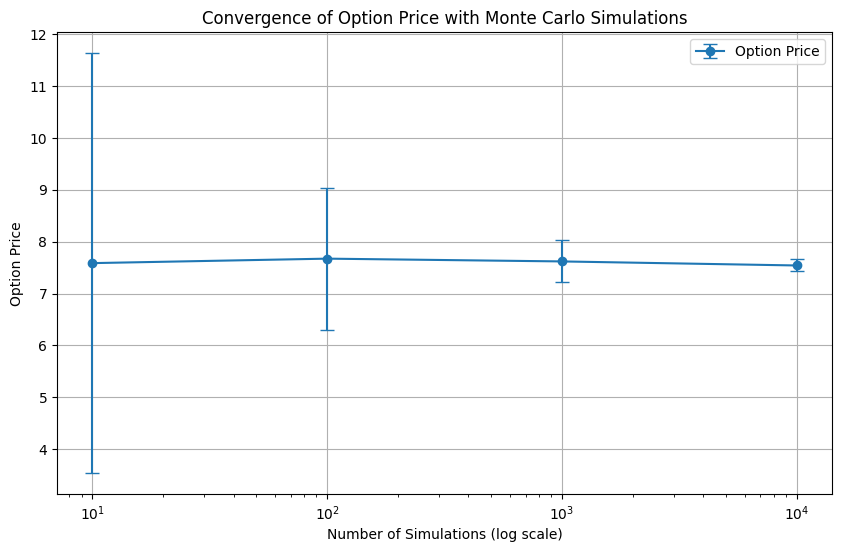

: 

In [5]:
# Function to calculate convergence with multiple simulation sizes
def convergence_test(s, r, vol, T, k, nb_steps, simulation_sizes, num_trials=100):
    avg_prices = []
    std_devs = []

    for nb_simul in simulation_sizes:
        prices = [mc_full_path(s, r, vol, T, k, "call", nb_simul, nb_steps)[0] for _ in range(num_trials)]
        avg_prices.append(np.mean(prices))
        std_devs.append(np.std(prices))

    return avg_prices, std_devs

# Simulation sizes to test convergence
simulation_sizes = [10, 100, 1000, 10000]
avg_prices, std_devs = convergence_test(s, r, vol, T, k, nb_steps, simulation_sizes)

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.errorbar(simulation_sizes, avg_prices, yerr=std_devs, fmt='-o', capsize=5, label='Option Price')
plt.xscale('log')
plt.xlabel('Number of Simulations (log scale)')
plt.ylabel('Option Price')
plt.title('Convergence of Option Price with Monte Carlo Simulations')
plt.grid(True)
plt.legend()
plt.show()